> **Note:** In most sessions you will be solving exercises posed in a Jupyter notebook that looks like this one. Because you are cloning a Github repository that only we can push to, you should **NEVER EDIT** any of the files you pull from Github. Instead, what you should do, is either make a new notebook and write your solutions in there, or **make a copy of this notebook and save it somewhere else** on your computer, not inside the `sds` folder that you cloned, so you can write your answers in there. If you edit the notebook you pulled from Github, those edits (possible your solutions to the exercises) may be overwritten and lost the next time you pull from Github. This is important, so don't hesitate to ask if it is unclear.

# Exercise Set 13: Model building process and model selection

*Morning, August 21, 2018*

In this Exercise Set 13 we will investigate how to build machine learning models using a formalize pipeline from preprocessed (i.e. tidy) data to a model.

We import our standard stuff. Notice that we are not interested in seeing the convergence warning in scikit-learn so we suppress them for now.

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

C:\Users\bvq720\AppData\Local\Continuum\miniconda3\envs\Python3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Model validation

In what follows we will regard the "train" data for two purposes. First we are interested in performing a model selection. Then with the selected model we estimate/train it on all the training data. 


> **Ex. 13.1.0:** Begin by reloading the housing dataset from Ex. 12.2.0 using the code below. 

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_house = fetch_california_housing()    
X = pd.DataFrame(data=cal_house['data'], 
                 columns=cal_house['feature_names'])\
             .iloc[:,:-2]
y = cal_house['target']

> **Ex. 13.1.1:** Make a for loop with 10 iterations where you:
1. Split the input data into, train and test where the sample of test should be one third. (Set a new random state for each iteration of the loop, so each iteration makes a different split)
2. Further split the training data  into to even sized bins; the first data is for training models and the other is for validation. 
3. Train a linear regression model with sub-training data. Compute the RMSE for out-of-sample predictions on test and validation data. Save the RMSE.

> You should now have a 10x2 DataFrame with 10 RMSE from both the test data set and the train data set. Compute descriptive statistics of RMSE for the out-of-sample predictions on test and validation data. Are the simular?    
>   They hopefuly are pretty simular. This shows us, that we can split the train data, and use this to fit the model. 

>> *Hint*: you can reuse any code used to solve exercises 12.2.X.

In [5]:
# [Answer to Ex. 13.1.1]

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

output = []

for random_state in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=random_state)    
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=random_state)

    reg = LinearRegression().fit(X_train, y_train)
    reg.predict(X_test)

    output.append([rmse(reg.predict(X_val), y_val),
                   rmse(reg.predict(X_test), y_test)])
    
pd.DataFrame(output, columns=['test', 'validation']).describe()

,test,validation
count,10.000000,10.000000
mean,1.143827,1.101885
std,0.978098,0.658022
min,0.777620,0.773043
25%,0.781633,0.787416
50%,0.794827,0.794032
75%,0.800074,0.809688
max,3.899375,2.504750


## Model building

> **Ex. 13.1.2:** Construct a model building pipeline which 

> 1. adds polynomial features without bias;
> 1. scales the features to mean zero and unit std. 
> 1. estimates a Lasso model

>> *Hint:* a modelling pipeline can be constructed with `make_pipeline` from `sklearn.pipeline`.

In [7]:
# [Answer to Ex. 13.1.2]

In [8]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

pipe_lasso = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),                           
                           StandardScaler(),
                           Lasso(random_state=1))

## Cross validation
In machine learning, we have two types of parameters: those that are learned from
the training data, for example, the weights in logistic regression, and the parameters
of a learning algorithm that are optimized separately. The latter are the tuning
parameters, also called *hyperparameters*, of a model, for example, the regularization
parameter in logistic regression or the depth parameter of a decision tree.
  
   
When we want to optimize over both normal parameters and hyperparameteres we do this using nested loops (two-layered cross validation). In outer loop we vary the hyperparameters, and then in the inner loop we do cross validation for the model with the specific selection of hyperparameters. This way we can find the model, with the lowest mean MSE. 

> **Ex. 13.1.3:**
Run a Lasso regression using the Pipeline from `Ex 13.1.2`. In the outer loop searching through the lambdas specified below. 
In the inner loop make 5 fold cross validation on the selected model and store the average MSE for each fold. Which lambda gives the lowest test MSE?


> ```python 
lambdas =  np.logspace(-4, 4, 12)
```

>> *Hint:* `KFold` in `sklearn.model_selection` may be useful.

In [9]:
# [Answer to Ex. 13.1.3]

# This will be in assignment 2

> **Ex. 13.1.4:** Automated Cross Validation in one dimension. 
Now we want to repeat exercise 13.1.3 in a more automated fasion. 
When you are doing cross validation with one hyperparameter, you can automate the process by using `validation_curve` from `sklearn.model_selection`. Use this function to search through the values of lambda, and find the value of lambda, which give the lowest test error.  

> check if you got the same output for the manual implementation (Ex. 13.1.3) and the automated implementation (Ex. 13.1.4) 

> BONUS: Plot the average MSE-test and MSE-train against the different values of lambda. (*Hint*: Use logarithmic axes, and lambda as index)

In [11]:
# [Answer to Ex. 13.1.4]

In [12]:
from sklearn.model_selection import validation_curve

lambdas =  np.logspace(-4, 4, 12)

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_train,
                     y=y_train,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=5)

mean_values = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
                         'test': pd.DataFrame(-test_scores).mean(1), 
                         'lambda': pd.DataFrame(lambdas).mean(1)}, axis =1)

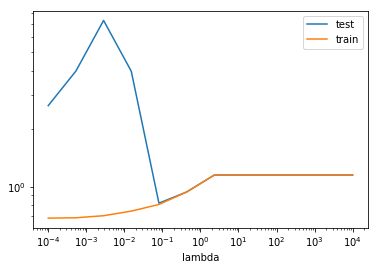

In [13]:
# answer to plotting bonus question

from sklearn.metrics import mean_squared_error as mse

def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))


# plot the 
pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(lambdas, name='lambda'))\
    .plot(logx=True, logy=True)

plt.show()

When you have *more that one* hyperparameter, you will want to fit the model to all the possible combinations of hyperparameters. This is done in an approch called `Grid Search`, which is implementet in `sklearn.model_selection` as `GridSearchCV`

> **Ex. 13.1.5:** To get to know `Grid Search` we want to implement in one dimension. Using `GridSearchCV` implement the Lasso, with the same lambdas as before (`lambdas =  np.logspace(-4, 4, 12)`), 10-fold CV and (negative) mean squared error as the scoring variable. Which value of Lambda gives the lowest test error? 

In [14]:
# [Answer to Ex. 13.1.5]

In [15]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator=pipe_lasso, 
                  param_grid=[{'lasso__alpha':lambdas}], 
                  scoring='neg_mean_squared_error', 
                  cv=10, 
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_params_)

{'lasso__alpha': 0.08111308307896872}


> **Ex. 13.1.6 BONUS** Expand the Lasso pipe from the last excercise with a Principal Component Analisys (PCA), and expand the Grid Search to searching in two dimensions (both along the values of lambda and the values of principal components (n_components)). Is `n_components` a hyperparameter? Which hyperparameters does the Grid Search select as the best?

> NB. This might take a while to calculate. 

In [16]:
# [Answer to Ex. 13.1.6]

In [17]:
from sklearn.decomposition import PCA

pipe_sq_pca_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                                  StandardScaler(),
                                  PCA(),
                                  Lasso())


gs = GridSearchCV(estimator=pipe_sq_pca_lasso, 
                  param_grid=[{'lasso__alpha':lambdas, 
                               'pca__n_components':range(1, X_train.shape[1]+1)}], 
                  scoring='neg_mean_squared_error', 
                  cv=10, 
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
# Yes, n_components is a hyperparameter. 
print(gs.best_params_)

{'pca__n_components': 6, 'lasso__alpha': 0.002848035868435802}


> **Ex. 13.1.7 BONUS** repeat the previous now with RandomizedSearchCV with 20 iterations.

In [18]:
# [Answer to Ex. 13.1.7]

In [19]:
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

pipe_sq_pca_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                                  StandardScaler(),
                                  PCA(),
                                  Lasso())


gs = RandomizedSearchCV(estimator=pipe_sq_pca_lasso, 
                        param_grid=[{'lasso__alpha':lambdas, 
                                     'pca__n_components':range(1, X_train.shape[1]+1)}], 
                        scoring='neg_mean_squared_error', 
                        cv=10, 
                        n_jobs=-1,
                        n_iter=20)

gs = gs.fit(X_train, y_train)
# Yes, n_components is a hyperparameter. 
print(gs.best_params_)



> **Ex. 13.1.8 BONUS** read about nested cross validation. How might we implement this in answer 13.1.6?


In [20]:
# [Answer to Ex. 13.1.8]